In [12]:
import pandas as pd
import numpy as np
import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/modeling_data.csv')
df.drop(columns='Unnamed: 0', inplace=True)

In [3]:
df['Date_Time'] = pd.to_datetime(df['Date_Time'])
df.set_index('Date_Time', inplace=True)
df.sort_index(inplace=True)

In [5]:
data = df.filter(['BO'])
data.head()

,BO
Date_Time,
2005-05-02,1.285468
2005-05-03,1.286334
2005-05-04,1.294374
2005-05-05,1.295118
2005-05-06,1.289243


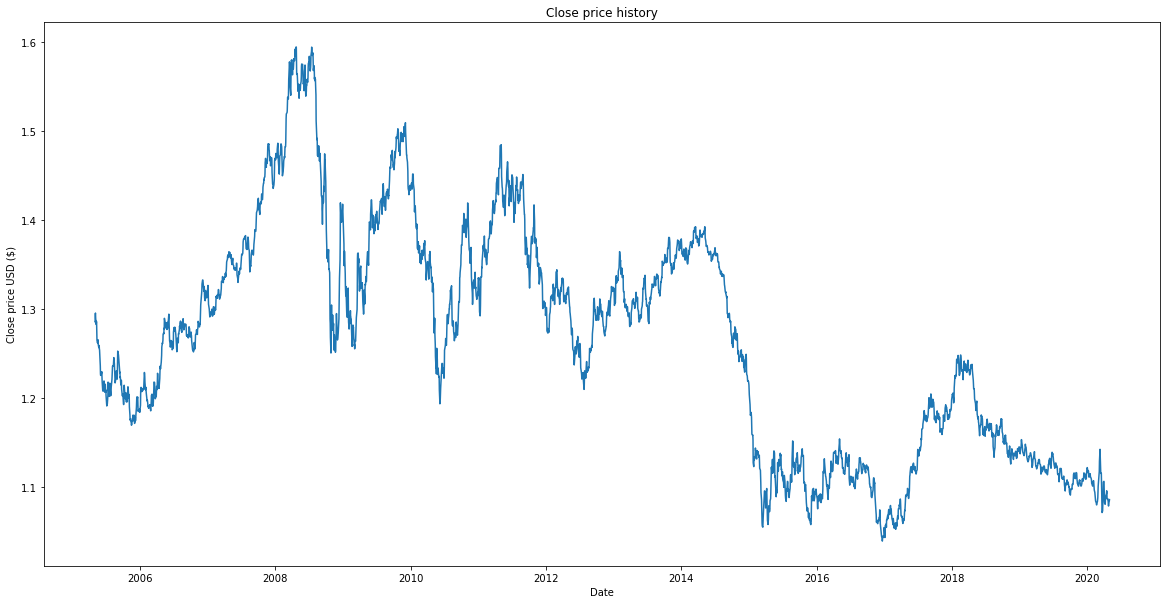

In [7]:
plt.figure(figsize=(20,10))
plt.title('Close price history')
plt.plot(data['BO'])
plt.xlabel('Date')
plt.ylabel('Close price USD ($)')
plt.show()

In [8]:
dataset = data.values

In [9]:
training_data_len = math.ceil(len(dataset)*0.85)

In [31]:
print('Length of the training dataset: {}'.format(training_data_len))

Length of the training dataset: 3185


In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [14]:
scaled_data

array([[0.44402451],
       [0.44558401],
       [0.46006532],
       ...,
       [0.08026561],
       [0.0806311 ],
       [0.08392115]])

In [15]:
window = 30

In [16]:
train_data = scaled_data[0:training_data_len,:]
x_train = []
y_train = []

for i in range(window, len(train_data)):
    x_train.append(train_data[i-window:i, 0])
    y_train.append(train_data[i, 0])

In [17]:
print('The train dataset {}, and the labels {}'.format(len(x_train), len(y_train)))

The train dataset 3155, and the labels 3155


In [18]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [19]:
print('The shape of x_train: {}\nThe shape of y_train: {}' .format(x_train.shape, y_train.shape))

The shape of x_train: (3155, 30)
The shape of y_train: (3155,)


In [21]:
x_train = np.reshape(x_train, newshape=(x_train.shape[0], x_train.shape[1], 1))

In [22]:
print('The new shape of x_train: {}'.format(x_train.shape))

The new shape of x_train: (3155, 30, 1)


In [23]:
def create_model():
    return Sequential(
    [LSTM(50, return_sequences=True, input_shape= (None, 1)),
    LSTM(50, return_sequences=False),
    Dense(100),
    Dense(50),
    Dense(1)])

In [24]:
model = create_model()
model.compile(optimizer='adam', loss='mean_squared_error')

In [25]:
hist = model.fit(x_train, y_train, batch_size=30, epochs=50)

Epoch 1/50
106/106 [==============================] - 3s 9ms/step - loss: 0.0093
Epoch 2/50
106/106 [==============================] - 1s 9ms/step - loss: 0.0010
Epoch 3/50
106/106 [==============================] - 1s 9ms/step - loss: 8.8603e-04
Epoch 4/50
106/106 [==============================] - 1s 9ms/step - loss: 7.9237e-04
Epoch 5/50
106/106 [==============================] - 1s 9ms/step - loss: 7.4512e-04
Epoch 6/50
106/106 [==============================] - 1s 9ms/step - loss: 6.4909e-04
Epoch 7/50
106/106 [==============================] - 1s 9ms/step - loss: 5.9867e-04
Epoch 8/50
106/106 [==============================] - 1s 9ms/step - loss: 5.3413e-04
Epoch 9/50
106/106 [==============================] - 1s 9ms/step - loss: 4.8346e-04
Epoch 10/50
106/106 [==============================] - 1s 9ms/step - loss: 4.7015e-04
Epoch 11/50
106/106 [==============================] - 1s 9ms/step - loss: 4.4926e-04
Epoch 12/50
106/106 [==============================] - 1s 9ms/step - lo

In [36]:
from sklearn.metrics import r2_score

In [41]:
r2_score(y_train, model.predict(x_train))

0.9955092638332601

In [26]:
window=30

In [27]:
test_data = scaled_data[training_data_len-window: , :]
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(window, len(test_data)):
      x_test.append(test_data[i-window:i,0])

In [28]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, newshape=(x_test.shape[0], x_test.shape[1], 1))
pred = model.predict(x_test)
pred = scaler.inverse_transform(pred)

<ipython-input-30-50d410d95d65>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = pred


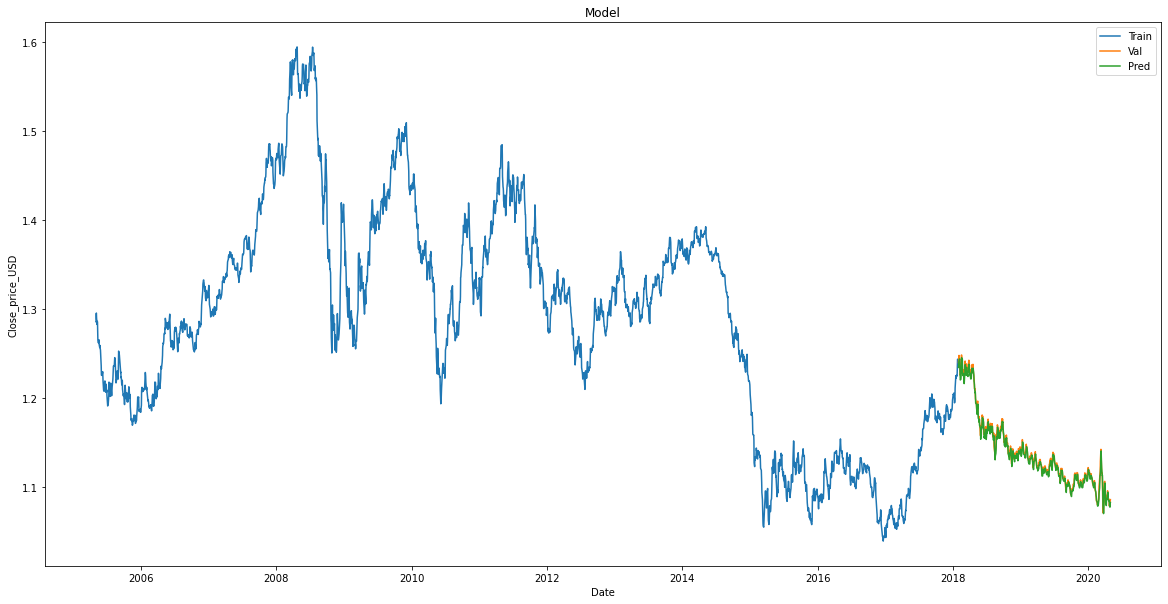

In [30]:
train = data[:training_data_len]
valid = data[training_data_len:]

valid['Predictions'] = pred

plt.figure(figsize=(20,10))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close_price_USD')
plt.plot(train['BO'])
plt.plot(valid[['BO', 'Predictions']])
plt.legend(['Train', 'Val','Pred'])
plt.show()

<ipython-input-33-a5c3b34331c7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = pred


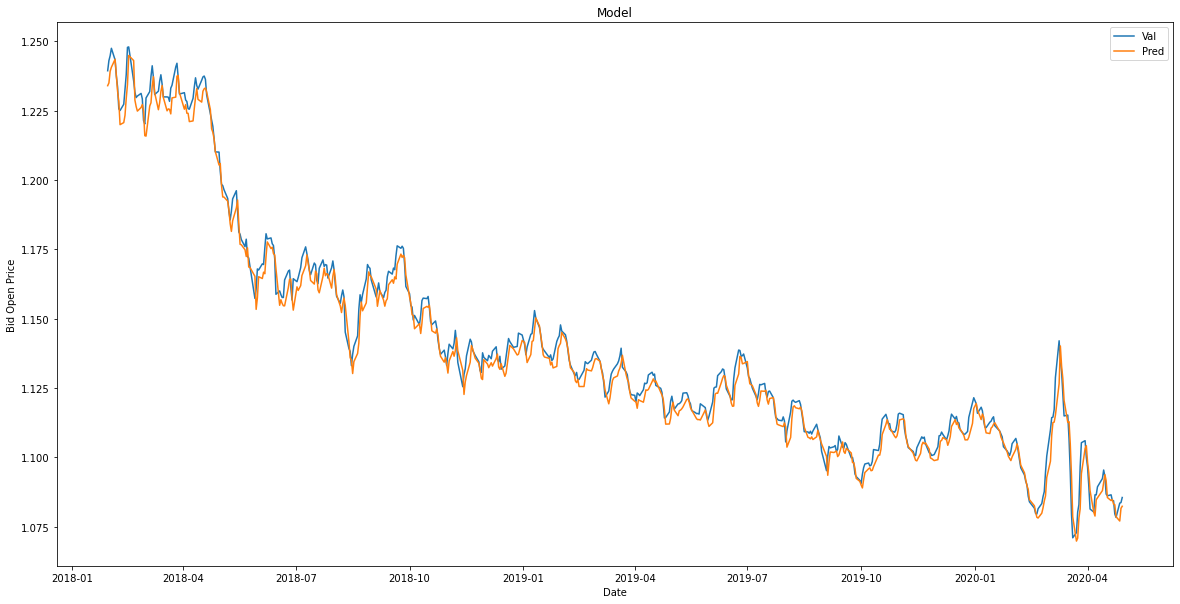

In [33]:
train = data[:training_data_len]
valid = data[training_data_len:]

valid['Predictions'] = pred

plt.figure(figsize=(20,10))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Bid Open Price')
plt.plot(valid[['BO', 'Predictions']])
plt.legend(['Val','Pred'])
plt.show()